# Goal: Calculate energy averages

What is the average of $E_1+E_2$?

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import os
import scipy.io as sio
import sys
import time
import inspect
import pandas as pd
from tqdm import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append('../scripts/')
import bicorr as bicorr
import bicorr_plot as bicorr_plot
import bicorr_e as bicorr_e
import bicorr_math as bicorr_math

# Load data for `bhm_e`

In [4]:
bhm_e, e_bin_edges, note = bicorr_e.load_bhm_e('../analysis/Cf072115_to_Cf072215b/datap')

In [5]:
det_df = bicorr.load_det_df()

In [6]:
dict_pair_to_index, dict_index_to_pair, dict_pair_to_angle = bicorr.build_dict_det_pair(det_df)

In [7]:
num_fissions = int(sio.loadmat(r'../analysis/Cf072115_to_Cf072215b/datap/num_fissions.mat')['num_fissions'])
num_fissions

2194651200

In [8]:
bhp_e, norm_factor = bicorr_e.build_bhp_e(bhm_e,e_bin_edges,num_fissions=num_fissions,print_flag=True)

Creating bhp_e for...
pair_is =  all
energy bin width (MeV) =  0.025
length of pair_is =  990
norm_factor =  1357940430.0000002


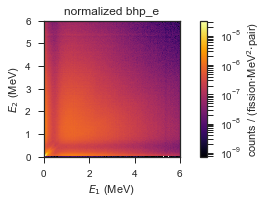

<Figure size 576x396 with 0 Axes>

In [9]:
bicorr_plot.bhp_e_plot(bhp_e, e_bin_edges, zoom_range=[0,6], title = "normalized bhp_e", show_flag = True)

# Restrict to narrow indices

In [19]:
E_min = 0.75
E_max = 4

In [22]:
i_E_min = np.digitize(E_min,e_bin_edges)-1
i_E_max = np.digitize(E_max,e_bin_edges)-1
print(i_E_min,i_E_max)

30 160


In [27]:
centers = bicorr_math.calc_centers(e_bin_edges)[i_E_min:i_E_max]
centers.shape

(130,)

In [31]:
X, Y = np.meshgrid(centers, centers)

In [32]:
H = bhp_e[i_E_min:i_E_max,i_E_min:i_E_max]

In [33]:
print(X.shape)
print(Y.shape)
print(H.shape)

(130, 130)
(130, 130)
(130, 130)


# Calculate average sum of energies

In [37]:
bicorr_math.calc_histogram_mean((X+Y)/2,H,True,True)

num:  0.01278272989117792
num_err:  0.16867930341498646
denom:  0.006244935943176828
denom_err:  0.07902490710641062
x_mean:  2.0468952776279856
x_mean_err: 37.422981528753866


(2.0468952776279856, 37.422981528753866)

# Vs. angle

I want to save this in a pandas DataFrame.

In [55]:
th_bin_edges = np.arange(8,190,10)
th_bin_centers = bicorr_math.calc_centers(th_bin_edges)
E_min = 0.75
E_max = 4

In [42]:
i_E_min = np.digitize(E_min,e_bin_edges)-1
i_E_max = np.digitize(E_max,e_bin_edges)-1
print(i_E_min,i_E_max)

30 160


In [56]:
Esum_df = pd.DataFrame({'th_bin_center':th_bin_centers})
Esum_df['Eave'] = np.nan
Esum_df['Eave_err'] = np.nan

In [58]:
Esum_df.head()

,th_bin_center,Eave,Eave_err
0,13.0,NaN,NaN
1,23.0,NaN,NaN
2,33.0,NaN,NaN
3,43.0,NaN,NaN
4,53.0,NaN,NaN


In [59]:
for th_i in range(len(th_bin_edges)-1):
    th_min = th_bin_edges[th_i]
    th_max = th_bin_edges[th_i+1]
    
    pair_is = bicorr.generate_pair_is(det_df,th_min=th_min,th_max=th_max)
    if len(pair_is) > 5: 
        bhp_e = bicorr_e.build_bhp_e(bhm_e,e_bin_edges,pair_is=pair_is)[0]
        H = bhp_e[i_E_min:i_E_max,i_E_min:i_E_max]
        Esum_df.loc[th_i,'Eave'], Esum_df.loc[th_i,'Eave_err'] = bicorr_math.calc_histogram_mean((X+Y)/2,H,False,True)

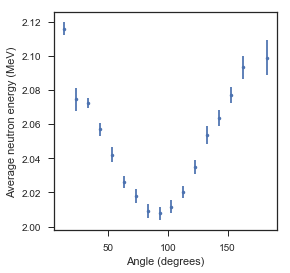

In [62]:
plt.figure(figsize=(4,4))
ax = plt.gca()
ax.errorbar(Esum_df['th_bin_center'],Esum_df['Eave'],yerr=Esum_df['Eave_err'],fmt='.')
plt.xlabel('Angle (degrees)')
plt.ylabel('Average neutron energy (MeV)')
plt.show()

In [ ]:
Esum_df.to_csv()